In this notebook we train the 4 NN architectures for 50x50 grid and then plot spatial plots, timeseries, scatterplots

python=3.8
tf=2.10
cuda=11.2
cudnn=8.1

**Imports**

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import csv
import math
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Reshape, Dropout, Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from keras import backend as K
from keras.constraints import MinMaxNorm
from keras.callbacks import LearningRateScheduler, EarlyStopping, Callback
from keras.metrics import RootMeanSquaredError
from keras.layers import Dropout,  TimeDistributed
from keras.regularizers import l2
from keras.initializers import HeNormal
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers, losses, metrics
import cmocean
tf.keras.backend.set_floatx('float64')

**Check to see if CUDA can find my GPU**

In [48]:
len(tf.config.list_physical_devices('GPU'))>0

True

**Read csv file into a df and drop 'zCOM' column as it's not needed**

In [31]:
sorted_concatenated_csv = "C:/Users/Ioannis/Documents/UvA thesis/UvA-thesis/data/test_data_concat/final run concat 100x100.csv"
data = pd.read_csv(sorted_concatenated_csv)
#data.drop(columns=['zCOM'], inplace=True)
print(data.head())

   mcsteps  xCOM  yCOM              il8   il1   il6  il10   tnf   tgf
0        0    78    62   [8.155469e-08]  [0.]  [0.]  [0.]  [0.]  [0.]
1        0    29    17   [3.716848e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
2        0    64    24  [3.4276149e-09]  [0.]  [0.]  [0.]  [0.]  [0.]
3        0    77    16  [3.7302027e-13]  [0.]  [0.]  [0.]  [0.]  [0.]
4        0    29     7  [3.9552712e-16]  [0.]  [0.]  [0.]  [0.]  [0.]


**Replace the 'mcsteps' column with 'time' and adjust the scale to represent 0-100 hours**

In [32]:
data['time'] = (data['mcsteps'] / 10000).astype(int)
data = data[['time'] + [col for col in data.columns if col != 'time']]
data.drop(columns=['mcsteps'], inplace=True)
print(data)

       time  xCOM  yCOM              il8              il1              il6  \
0         0    78    62   [8.155469e-08]             [0.]             [0.]   
1         0    29    17   [3.716848e-09]             [0.]             [0.]   
2         0    64    24  [3.4276149e-09]             [0.]             [0.]   
3         0    77    16  [3.7302027e-13]             [0.]             [0.]   
4         0    29     7  [3.9552712e-16]             [0.]             [0.]   
...     ...   ...   ...              ...              ...              ...   
33842   100    97    49  [1.4131037e-10]  [4.0171866e-09]  [4.0206436e-12]   
33843   100    62    90   [9.426965e-08]    [5.53244e-09]  [2.3352102e-08]   
33844   100     5    83   [3.467103e-11]   [1.923624e-08]   [4.866993e-11]   
33845   100    32    17  [1.6327994e-07]  [1.9637703e-09]  [4.1984766e-10]   
33846   100    86    51   [9.620416e-07]   [6.637888e-10]  [1.8478708e-13]   

                  il10              tnf               tgf  
0  

**Check for value ranges of the 6 cytokine columns**

In [33]:
cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
smallest_values = data[cytokine_columns].min()
largest_values = data[cytokine_columns].max()

print("Smallest values for each cytokine:")
print(smallest_values)
print("\nLargest values for each cytokine:")
print(largest_values)

Smallest values for each cytokine:
il8     [0.]
il1     [0.]
il6     [0.]
il10    [0.]
tnf     [0.]
tgf     [0.]
dtype: object

Largest values for each cytokine:
il8     [9.999916e-07]
il1     [9.999936e-10]
il6          [9.9e-43]
il10     [9.99949e-32]
tnf     [9.999565e-08]
tgf     [9.999223e-13]
dtype: object


**Replace negative 'il8' values with 0s (no need to run this after we fixed negative values)**

In [ ]:
def replace_negative_with_zero(data):
    num_negative_values = (data < 0).sum().sum()
    data[data < 0] = 0

    return num_negative_values

cytokine_columns = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

for col in cytokine_columns:
    num_negatives = replace_negative_with_zero(data[col])
    print(f"Number of negative values replaced with 0 in '{col}': {num_negatives}")

**Create 101 arrays (1 per timestep) to prepare the data to be input into a sequential model**

In [34]:
# define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

# get unique time values
unique_time = data['time'].unique()

arrays = {}

# iterate over unique time values
for time in unique_time:
    # filter data for current value of time
    data_time = data[data['time'] == time]
    
    # initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # get cytokine concentrations
    concentrations = data_time[['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']].values
    
    # assign cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    # store array for current value of time
    arrays[time] = array

IndexError: index 78 is out of bounds for axis 0 with size 50

**Run this cell if you want to normalize the values with minmax scaler per timestep, per cytokine while creating arrays**

In [7]:
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
concentrations_all = data[cytokines].values

scaler = MinMaxScaler()

scaler.fit(concentrations_all)

unique_time = data['time'].unique()

arrays = {}
scalers = {cytokine: MinMaxScaler() for cytokine in cytokines}
for time in unique_time:
    data_time = data[data['time'] == time]
    
    # Initialize 50x50x6 array for current value of time
    array = np.zeros((50, 50, len(cytokines)))
    
    # Get X and Y coordinates
    x = data_time['xCOM'].astype(int)
    y = data_time['yCOM'].astype(int)
    
    # Get cytokine concentrations
    concentrations = data_time[cytokines].values
    
    # Normalize each cytokine separately across all time steps
    for i, cytokine in enumerate(cytokines):
        # Fit and transform the current cytokine
        concentrations[:, i] = scalers[cytokine].fit_transform(concentrations[:, i].reshape(-1, 1)).flatten()
    
    # Assign scaled cytokine concentrations to corresponding position in array
    array[x, y, :] = concentrations
    
    arrays[time] = array

**Print arrays to crosscheck for errors with the corresponding csv file**

In [54]:
print("Number of arrays:", len(arrays))
array = arrays[0]
print("Shape of the array:", array.shape)
print("Value at position (18,35):", array[18,35])

Number of arrays: 101
Shape of the array: (50, 50, 6)
Value at position (18,35): [3.7056725e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00]


**Construct a 5D tensor that contains a sequence of arrays to be input to the model and a 4D tensor to contain the predictions**

In [55]:
sequence_length = 10
input_sequences = []
output_values = []

# convert dictionary values to a list of arrays
arrays_list = [arrays[key] for key in sorted(arrays.keys())]

# convert 'arrays' list to numpy array
arrays_np = np.array(arrays_list)

for i in range(len(arrays_np) - sequence_length):
    input_seq = arrays_np[i:i+sequence_length]  # input sequence of arrays
    output_val = arrays_np[i+sequence_length]   # array at next time step
    
    input_sequences.append(input_seq)
    output_values.append(output_val)

# convert lists to numpy arrays
input_sequences = np.array(input_sequences)
output_values = np.array(output_values)

**Print to check for errors**

In [21]:
print(input_sequences.shape)
print(output_values.shape)

(91, 10, 50, 50, 6)
(91, 50, 50, 6)


**Metrics and callbacks**

In [56]:
# define metrics, lr scheduler
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def r_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return 1 - SS_res/(SS_tot + K.epsilon())

def average_relative_rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None))))

#def average_relative_error(y_true, y_pred):
    return K.mean(K.abs((y_pred - y_true) / K.clip(K.abs(y_true), K.epsilon(), None)))

def accuracy(y_true, y_pred):
    abs_diff = K.abs(y_true - y_pred)
    threshold = 0.2 * y_true
    accurate_predictions = K.less_equal(abs_diff, threshold)
    accuracy = K.mean(accurate_predictions)
    return accuracy

#def explained_variance(y_true, y_pred):
    return 1 - K.var(y_true - y_pred) / K.var(y_true)

**Models**

**C-LSTM: relatively simple model with a 2D convolutional layer followed by 2 LSTM layers and a fully connected layer**

In [23]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 500:
        return 1e-4
    else:
        return 1e-4

train_size = int(0.7 * input_sequences.shape[0])
val_size = int(0.1 * input_sequences.shape[0])
test_size = input_sequences.shape[0] - train_size - val_size

X_train = input_sequences[:train_size]
X_val = input_sequences[train_size:train_size + val_size]
X_test = input_sequences[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

initial_lr = 1e-4
#optimizer = Adam(learning_rate=initial_lr, clipnorm=1.0)
#optimizer = Adam(learning_rate=initial_lr, clipvalue=0.5)
optimizer = Adam(learning_rate=initial_lr)
sequence_length = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_schedule)

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(sequence_length, 50, 50, 6)),
    Reshape((sequence_length, -1)),
    LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.03)),
    LSTM(units=64),
    Dense(units=50*50*6, activation='relu'),
    Reshape((50, 50, 6))
])

model.compile(optimizer=optimizer, loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, callbacks=[early_stopping, lr_scheduler_callback])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 50, 50, 6)
X_val shape: (9, 10, 50, 50, 6)
X_test shape: (19, 10, 50, 50, 6)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 15.0577 - r_squared: 0.3682 - mape: 7.4013 - accuracy: 0.4693 - average_relative_rmse: 0.1541 - msle: 3.5421e-13 - mae: 5.4183e-08 - val_loss: 14.2852 - val_r_squared: 0.5396 - val_mape: 10.3659 - val_accuracy: 0.4682 - val_average_relative_rmse: 0.1943 - val_msle: 6.2607e-13 - val_mae: 7.4331e-08 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - 1s 429ms/step - loss: 14.0404 - r_squared: 0.3755 - mape: 7.3349 - accuracy: 0.4691 - average_relative_rmse: 0.1528 - msle: 3.5318e-13 - mae: 5.3827e-08 - val_loss: 13.3024 - val_r_squared: 0.5454 - val_mape: 10.2787 - val_accuracy: 0.4665 - val_average_relative_rmse: 0.1932 - val_msle: 6.1927e-13 - val_mae: 7.3854e-08 - lr: 1.0000e-04
Epoch 3/500
2/2 [==================

In [31]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-4
    if epoch < 500:
        return 1e-4
    else:
        return 1e-4

train_size = int(0.7 * input_sequences.shape[0])
test_size = int(0.2 * input_sequences.shape[0])
val_size = input_sequences.shape[0] - train_size - test_size

X_train = input_sequences[:train_size]
X_test = input_sequences[train_size:train_size + test_size]
X_val = input_sequences[train_size + test_size:]

y_train = output_values[:train_size]
y_test = output_values[train_size:train_size + test_size]
y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

initial_lr = 1e-4
#optimizer = Adam(learning_rate=initial_lr, clipnorm=1.0)
#optimizer = Adam(learning_rate=initial_lr, clipvalue=0.5)
optimizer = Adam(learning_rate=initial_lr)
sequence_length = 10
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
lr_scheduler_callback = LearningRateScheduler(lr_schedule)

model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(sequence_length, 50, 50, 6)),
    Reshape((sequence_length, -1)),
    LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.03)),
    LSTM(units=64),
    Dense(units=50*50*6, activation='relu'),
    Reshape((50, 50, 6))
])

model.compile(optimizer=optimizer, loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32, callbacks=[early_stopping, lr_scheduler_callback])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 50, 50, 6)
X_val shape: (10, 10, 50, 50, 6)
X_test shape: (18, 10, 50, 50, 6)
y_train shape: (63, 50, 50, 6)
y_val shape: (10, 50, 50, 6)
y_test shape: (18, 50, 50, 6)
Epoch 1/500
2/2 [==============================] - 3s 1s/step - loss: 15.0503 - r_squared: 0.3671 - mape: 6.4822 - accuracy: 0.4707 - average_relative_rmse: 0.1413 - msle: 3.5421e-13 - mae: 5.3284e-08 - val_loss: 14.2780 - val_r_squared: 0.4720 - val_mape: 9.8660 - val_accuracy: 0.4706 - val_average_relative_rmse: 0.1893 - val_msle: 7.3682e-13 - val_mae: 7.9980e-08 - lr: 1.0000e-04
Epoch 2/500
2/2 [==============================] - 1s 455ms/step - loss: 14.0333 - r_squared: 0.3735 - mape: 6.5170 - accuracy: 0.4702 - average_relative_rmse: 0.1412 - msle: 3.5351e-13 - mae: 5.3070e-08 - val_loss: 13.2955 - val_r_squared: 0.4772 - val_mape: 9.9437 - val_accuracy: 0.4698 - val_average_relative_rmse: 0.1902 - val_msle: 7.3081e-13 - val_mae: 7.9710e-08 - lr: 1.0000e-04
Epoch 3/500
2/2 [==================

**CT-LSTM: more complex NN with timedistributed layers, maxpooling, and more neurons per layer**

In [57]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-3
    if epoch < 400:
        return 1e-4
    else:
        return 1e-5

train_size = int(0.7 * len(input_sequences))
val_size = int(0.1 * len(input_sequences))

X_train, y_train = input_sequences[:train_size], output_values[:train_size]
X_val, y_val = input_sequences[train_size:train_size+val_size], output_values[train_size:train_size+val_size]
X_test, y_test = input_sequences[train_size+val_size:], output_values[train_size+val_size:]

def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

input_shape = (sequence_length, 50, 50, 6)
model = build_model(input_shape)
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-3

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', 'accuracy', average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[lr_scheduler, early_stopping])

test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

Epoch 1/500
4/4 [==============================] - 12s 1s/step - loss: 7.8185 - r_squared: 0.5745 - mape: 10.4253 - accuracy: 0.1852 - average_relative_rmse: 0.1983 - msle: 3.2963e-13 - mae: 5.5195e-08 - val_loss: 4.7193 - val_r_squared: 0.6264 - val_mape: 17.3626 - val_accuracy: 0.1955 - val_average_relative_rmse: 0.3382 - val_msle: 5.0863e-13 - val_mae: 7.4795e-08 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 2s 431ms/step - loss: 3.5019 - r_squared: 0.6994 - mape: 16.7151 - accuracy: 0.1992 - average_relative_rmse: 0.3056 - msle: 2.3178e-13 - mae: 5.3035e-08 - val_loss: 1.8461 - val_r_squared: 0.7351 - val_mape: 18.7724 - val_accuracy: 0.2016 - val_average_relative_rmse: 0.4728 - val_msle: 3.5927e-13 - val_mae: 6.5901e-08 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 2s 435ms/step - loss: 1.2883 - r_squared: 0.8001 - mape: 15.8286 - accuracy: 0.2085 - average_relative_rmse: 0.3228 - msle: 1.5307e-13 - mae: 4.2540e-08 - val_loss: 0.5960 - val_r_squ

In [36]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-3
    if epoch < 400:
        return 1e-4
    else:
        return 1e-5

train_size = int(0.7 * input_sequences.shape[0])
test_size = int(0.2 * input_sequences.shape[0])
val_size = input_sequences.shape[0] - train_size - test_size

X_train = input_sequences[:train_size]
X_test = input_sequences[train_size:train_size + test_size]
X_val = input_sequences[train_size + test_size:]

y_train = output_values[:train_size]
y_test = output_values[train_size:train_size + test_size]
y_val = output_values[train_size + test_size:]

def build_model(input_shape):
    input_layer = layers.Input(shape=input_shape)
    
    
    x = layers.TimeDistributed(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))(input_layer)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    x = layers.TimeDistributed(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))(x)
    x = layers.TimeDistributed(layers.MaxPooling2D((2, 2)))(x)
    
    x = layers.Reshape((input_shape[0], -1))(x)
    x = layers.LSTM(128, return_sequences=True,kernel_regularizer=l2(0.01))(x)
    x = layers.LSTM(64)(x)
    
    x = layers.Dense(50 * 50 * 6, activation='relu')(x)
    output_layer = layers.Reshape((50, 50, 6))(x)
    
    model = models.Model(inputs=input_layer, outputs=output_layer)
    
    return model

input_shape = (sequence_length, 50, 50, 6)
model = build_model(input_shape)
lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-3

model.compile(optimizer='adam', loss='mse', metrics=[r_squared, 'mape', 'accuracy', average_relative_rmse, 'msle', 'mae'])

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=16, callbacks=[lr_scheduler, early_stopping])

test_metrics = model.evaluate(X_test, y_test)
print(f'Test Metrics: {test_metrics}')

Epoch 1/500
4/4 [==============================] - 5s 903ms/step - loss: 7.8225 - r_squared: 0.5748 - mape: 10.8763 - accuracy: 0.1970 - average_relative_rmse: 0.2047 - msle: 3.2868e-13 - mae: 5.5633e-08 - val_loss: 4.7222 - val_r_squared: 0.5679 - val_mape: 19.0629 - val_accuracy: 0.2041 - val_average_relative_rmse: 0.3611 - val_msle: 6.0456e-13 - val_mae: 8.2452e-08 - lr: 0.0010
Epoch 2/500
4/4 [==============================] - 2s 424ms/step - loss: 3.5042 - r_squared: 0.7035 - mape: 18.6150 - accuracy: 0.2029 - average_relative_rmse: 0.3372 - msle: 2.2899e-13 - mae: 5.4629e-08 - val_loss: 1.8476 - val_r_squared: 0.6907 - val_mape: 20.9983 - val_accuracy: 0.2078 - val_average_relative_rmse: 0.4977 - val_msle: 4.3149e-13 - val_mae: 7.3657e-08 - lr: 0.0010
Epoch 3/500
4/4 [==============================] - 2s 421ms/step - loss: 1.2894 - r_squared: 0.8088 - mape: 17.4698 - accuracy: 0.2107 - average_relative_rmse: 0.3408 - msle: 1.4686e-13 - mae: 4.3725e-08 - val_loss: 0.5965 - val_r_s

**STA-LSTM: NN incorporating lstm layer, spatiotemporal attention layers followed by fully connected layers**

In [39]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.V = tf.keras.layers.Dense(1)

    def call(self, lstm_output, input_data):
        # attention weights
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        
        # apply attention to LSTM output
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc2 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc3 = tf.keras.layers.Dense(tf.reduce_prod(input_shape[1:]), activation='relu')  # adjust output size
        self.reshape = tf.keras.layers.Reshape(input_shape[1:])  # reshape to match output shape
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))  # flatten for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.fc3(x)
        output = self.reshape(output)  # reshape to match input shape
        return output

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

model = STALSTM(hidden_size=64, input_shape=input_shape)

# build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])  # take a sample batch
_ = model(sample_input)  # calling the model on a sample input to build it

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'] )

print(model.summary())

history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(91, 10, 15000)
X_train shape: (63, 10, 15000)
X_val shape: (9, 10, 15000)
X_test shape: (19, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
(10, 50, 50, 6)
Model: "stalstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              multiple                  3856640   
                                                                 
 spatial_temporal_attention_  multiple                 964289    
 1 (SpatialTemporalAttention                                     
 )                                                               
                                                                 
 dense_14 (Dense)            multiple                  3250      
                                                                 
 dense_15 (Dense)            multiple                  2550      
                                             

None
Epoch 1/1000
16/16 [==============================] - 2s 51ms/step - loss: 1.0539 - r_squared: 0.8245 - mape: 8.6385 - accuracy: 0.4713 - average_relative_rmse: 0.1720 - msle: 3.5421e-13 - mae: 5.5451e-08 - val_loss: 1.0538 - val_r_squared: 0.7858 - val_mape: 12.1077 - val_accuracy: 0.4698 - val_average_relative_rmse: 0.2222 - val_msle: 6.2632e-13 - val_mae: 7.6266e-08 - lr: 1.0000e-06
Epoch 2/1000
16/16 [==============================] - 0s 25ms/step - loss: 1.0537 - r_squared: 0.8251 - mape: 8.6469 - accuracy: 0.4712 - average_relative_rmse: 0.1723 - msle: 3.5421e-13 - mae: 5.5402e-08 - val_loss: 1.0536 - val_r_squared: 0.7863 - val_mape: 12.1216 - val_accuracy: 0.4696 - val_average_relative_rmse: 0.2224 - val_msle: 6.2632e-13 - val_mae: 7.6207e-08 - lr: 1.0000e-06
Epoch 3/1000
16/16 [==============================] - 0s 25ms/step - loss: 1.0535 - r_squared: 0.8257 - mape: 8.6590 - accuracy: 0.4713 - average_relative_rmse: 0.1720 - msle: 3.5421e-13 - mae: 5.5327e-08 - val_loss: 

In [42]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-6
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4

class SpatialTemporalAttention(tf.keras.layers.Layer):
    def __init__(self, hidden_size):
        super(SpatialTemporalAttention, self).__init__()
        self.hidden_size = hidden_size
        self.W_s = tf.keras.layers.Dense(hidden_size)
        self.W_t = tf.keras.layers.Dense(hidden_size)
        self.V = tf.keras.layers.Dense(1)

    def call(self, lstm_output, input_data):
        # attention weights
        spatial_attention = tf.tanh(self.W_s(lstm_output))
        temporal_attention = tf.tanh(self.W_t(input_data))
        attention_scores = self.V(spatial_attention * temporal_attention)
        attention_weights = tf.nn.softmax(attention_scores, axis=1)
        
        # apply attention to LSTM output
        attended_output = tf.matmul(tf.transpose(attention_weights, [0, 2, 1]), lstm_output)
        return attended_output

class STALSTM(tf.keras.Model):
    def __init__(self, hidden_size, input_shape):
        super(STALSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.attention = SpatialTemporalAttention(hidden_size)
        self.fc1 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc2 = tf.keras.layers.Dense(50, activation='relu',  kernel_regularizer=l2(0.01))
        self.fc3 = tf.keras.layers.Dense(tf.reduce_prod(input_shape[1:]), activation='relu')  # adjust output size
        self.reshape = tf.keras.layers.Reshape(input_shape[1:])  # reshape to match output shape
        self.input_shape_model = input_shape

    def call(self, input_data):
        lstm_output = self.lstm(input_data)
        attended_output = self.attention(lstm_output, input_data)
        x = tf.reshape(attended_output, (-1, self.hidden_size))  # flatten for fully connected layers
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.fc3(x)
        output = self.reshape(output)  # reshape to match input shape
        return output

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)
print(input_sequences_reshaped.shape)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
test_size = int(0.2 * input_sequences_reshaped.shape[0])
val_size = input_sequences_reshaped.shape[0] - train_size - test_size

X_train = input_sequences_reshaped[:train_size]
X_test = input_sequences_reshaped[train_size:train_size + test_size]
X_val = input_sequences_reshaped[train_size + test_size:]

y_train = output_values[:train_size]
y_test = output_values[train_size:train_size + test_size]
y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

input_shape = input_sequences.shape[1:]
print(input_shape)

model = STALSTM(hidden_size=64, input_shape=input_shape)

# build the model by calling it on a batch of data
sample_input = tf.convert_to_tensor(X_train[:1])  # take a sample batch
_ = model(sample_input)  # calling the model on a sample input to build it

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
initial_lr = 1e-6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=initial_lr), loss='mse',  metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'] )

print(model.summary())

history = model.fit(X_train, y_train, epochs=1000, batch_size=4, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

(91, 10, 15000)
X_train shape: (63, 10, 15000)
X_val shape: (10, 10, 15000)
X_test shape: (18, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (10, 50, 50, 6)
y_test shape: (18, 50, 50, 6)
(10, 50, 50, 6)
Model: "stalstm_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              multiple                  3856640   
                                                                 
 spatial_temporal_attention_  multiple                 964289    
 2 (SpatialTemporalAttention                                     
 )                                                               
                                                                 
 dense_20 (Dense)            multiple                  3250      
                                                                 
 dense_21 (Dense)            multiple                  2550      
                                           

**LSTM: basic lstm model with 3 stacked lstm layers and 4 fully connected layers**

In [44]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4
    
#def lr_range_test(epoch, lr):
    # Start with a very small learning rate and increase exponentially
    return 10 ** (epoch / 20)  # Adjust the exponent as needed

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length =10

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
val_size = int(0.1 * input_sequences_reshaped.shape[0])
test_size = input_sequences_reshaped.shape[0] - train_size - val_size

X_train = input_sequences_reshaped[:train_size]
X_val = input_sequences_reshaped[train_size:train_size + val_size]
X_test = input_sequences_reshaped[train_size + val_size:]
y_train = output_values[:train_size]
y_val = output_values[train_size:train_size + val_size]
y_test = output_values[train_size + val_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=50 * 50 * 6, activation='relu'))
model.add(Reshape((50, 50, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=600, batch_size=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 15000)
X_val shape: (9, 10, 15000)
X_test shape: (19, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (9, 50, 50, 6)
y_test shape: (19, 50, 50, 6)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 10, 256)           15623168  
                                                                 
 lstm_14 (LSTM)              (None, 10, 256)           525312    
                                                                 
 lstm_15 (LSTM)              (None, 256)               525312    
                                                                 
 dense_23 (Dense)            (None, 256)               65792     
                                                                 
 dense_24 (Dense)            (None, 256)               65792     
                                                                 
 dense_2

In [48]:
def lr_schedule(epoch, lr):
    if epoch < 100:
        return 1e-2
    if epoch < 500:
        return 1e-3
    else:
        return 1e-4
    
#def lr_range_test(epoch, lr):
    # Start with a very small learning rate and increase exponentially
    return 10 ** (epoch / 20)  # Adjust the exponent as needed

lr_scheduler = LearningRateScheduler(lr_schedule)
early_stopping = EarlyStopping(monitor='val_loss', patience=150, verbose=1, restore_best_weights=True)

initial_lr = 1e-2
sequence_length =10

input_sequences_reshaped = input_sequences.reshape(input_sequences.shape[0], input_sequences.shape[1], -1)

train_size = int(0.7 * input_sequences_reshaped.shape[0])
test_size = int(0.2 * input_sequences_reshaped.shape[0])
val_size = input_sequences_reshaped.shape[0] - train_size - test_size

X_train = input_sequences_reshaped[:train_size]
X_test = input_sequences_reshaped[train_size:train_size + test_size]
X_val = input_sequences_reshaped[train_size + test_size:]

y_train = output_values[:train_size]
y_test = output_values[train_size:train_size + test_size]
y_val = output_values[train_size + test_size:]

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

model = Sequential()
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256, return_sequences=True, input_shape=(sequence_length, 50 * 50 * 6), kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(LSTM(units=256))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
#model.add(Dropout(0.2)) 
model.add(Dense(units=256, kernel_regularizer=l2(0.03)))
model.add(Dense(units=50 * 50 * 6, activation='relu'))
model.add(Reshape((50, 50, 6)))
model.compile(optimizer=Adam(learning_rate=initial_lr), loss='mse', metrics=[r_squared, 'mape', accuracy, average_relative_rmse, 'msle', 'mae'])
print(model.summary())

history = model.fit(X_train, y_train, epochs=600, batch_size=100, validation_data=(X_val, y_val), callbacks=[lr_scheduler, early_stopping])
print("Training Loss:", history.history['loss'])

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

X_train shape: (63, 10, 15000)
X_val shape: (10, 10, 15000)
X_test shape: (18, 10, 15000)
y_train shape: (63, 50, 50, 6)
y_val shape: (10, 50, 50, 6)
y_test shape: (18, 50, 50, 6)
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 10, 256)           15623168  
                                                                 
 lstm_20 (LSTM)              (None, 10, 256)           525312    
                                                                 
 lstm_21 (LSTM)              (None, 256)               525312    
                                                                 
 dense_31 (Dense)            (None, 256)               65792     
                                                                 
 dense_32 (Dense)            (None, 256)               65792     
                                                                 
 dense

**export in CSV the prediction for test set**

In [49]:
y_pred = model.predict(X_test)

y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Create arrays for x and y coordinates
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Initialize a list to hold all data for the DataFrame
all_data = []

# Loop through each timestep and collect the data
for timestep in range(y_pred_shape[0]):
    y_pred_timestep = y_pred_flattened[timestep]
    for i in range(y_pred_timestep.shape[0]):
        data_point = {'timestep': timestep, 'X': X[i], 'Y': Y[i]}
        data_point.update({f'feature_{j+1}': y_pred_timestep[i, j] for j in range(y_pred_shape[-1])})
        all_data.append(data_point)

# Create the DataFrame
df_all_timesteps = pd.DataFrame(all_data)

# Save the DataFrame to a CSV file
df_all_timesteps.to_csv('data/CT-LSTM(50x50)(72-89hrs).csv', index=False)

1/1 [==============================] - 1s 588ms/step


**Plot the training and validation loss**

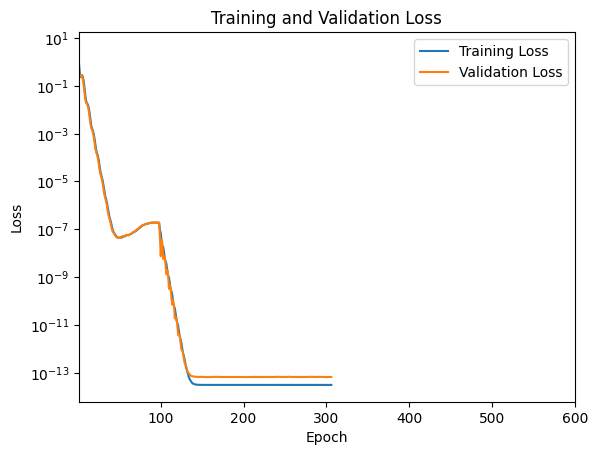

Loss data saved to plots(50x50)/plots-CT-LSTM\CT-LSTM-loss_data.csv


In [58]:
train_loss = history.history['loss'][1:600]
val_loss = history.history['val_loss'][1:600]

output_dir = 'plots(50x50)/plots-CT-LSTM'
os.makedirs(output_dir, exist_ok=True)

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xlim(1, 600)  # Force the x-axis scale to be from 1 to 1500
plot_filename = f'loss.png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

# Exporting the data for loss to a CSV file
loss_data = {
    'Epoch': list(range(1, len(train_loss) + 1)),  # Adjusting the length to match the loss data
    'Training Loss': train_loss,
    'Validation Loss': val_loss
}
loss_df = pd.DataFrame(loss_data)
csv_filename = 'CT-LSTM-loss_data.csv'
csv_path = os.path.join(output_dir, csv_filename)
loss_df.to_csv(csv_path, index=False)

print(f'Loss data saved to {csv_path}')

**Plot the actual against the predicted values for all 6 cytokines at t=82**

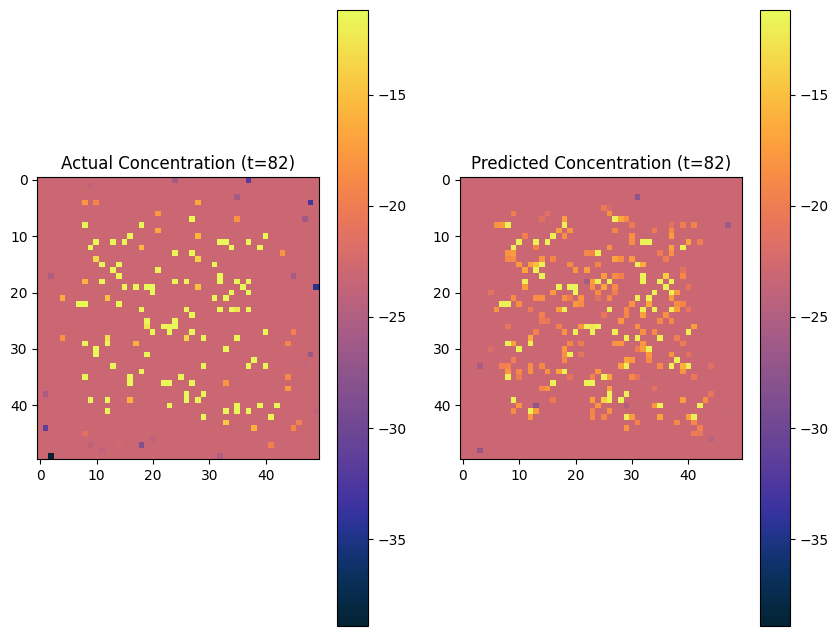

In [29]:
timesteps = [0]

# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)

for t in timesteps:
    # Get the flattened values for the specified timestep
    y_pred_timestep = y_pred_flattened[t]
    y_test_timestep = y_test_flattened[t]

    # Avoid log(0) by replacing non-positive values
    y_pred_timestep = np.where(y_pred_timestep <= 0, epsilon, y_pred_timestep)
    y_test_timestep = np.where(y_test_timestep <= 0, epsilon, y_test_timestep)

    # Apply log scale
    log_y_test_flattened = np.log(y_test_timestep)
    log_y_pred_flattened = np.log(y_pred_timestep)

    # Reshape the feature data to a 50x50 grid
    y_test_grid = np.reshape(log_y_test_flattened[:, 0], (50, 50))
    y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (50, 50))

    # Calculate vmin and vmax to handle log transformation correctly
    vmin = min(y_test_grid.min(), y_pred_grid.min())
    vmax = max(y_test_grid.max(), y_pred_grid.max())

    plt.figure(figsize=(10, 8))

    # Plotting actual values
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Actual Concentration (t={t+82})')
    plt.colorbar(im1)

    # Plotting predicted values
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Concentration (t={t+82})')
    plt.colorbar(im2)

    # Save the plot to the specified folder
    output_dir = 'plots(50x50)/plots-C-LSTM'
    plot_filename = f'{timesteps.index(t) + 1}_grid at t={t+82}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()

**Plot the actual against the predicted values for all 6 cytokines at t=92, t=100**

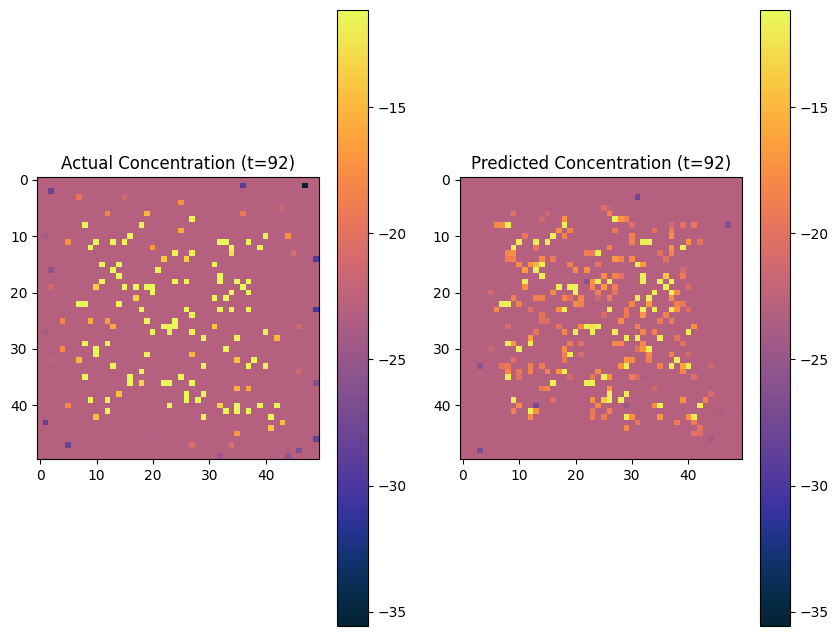

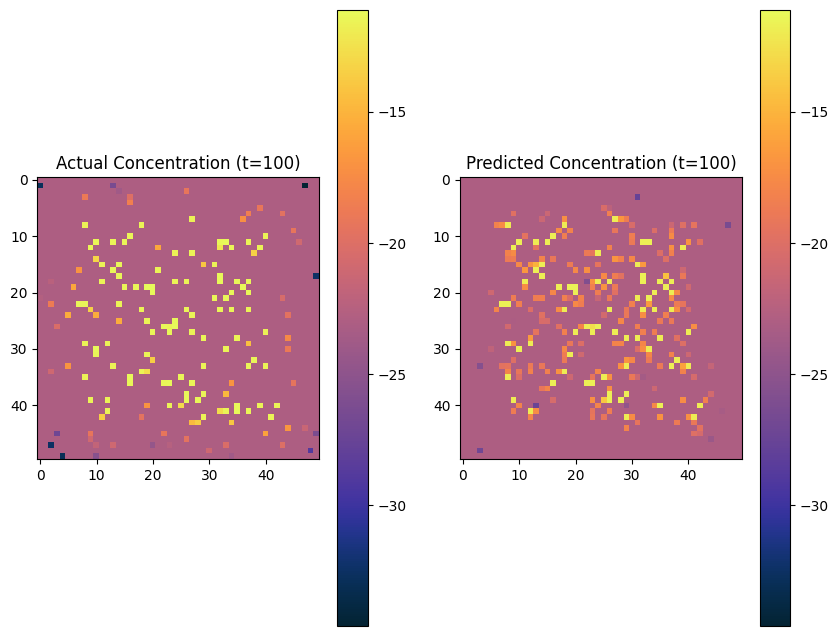

In [30]:
timesteps = [10, 18]

# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)

for t in timesteps:
    # Get the flattened values for the specified timestep
    y_pred_timestep = y_pred_flattened[t]
    y_test_timestep = y_test_flattened[t]

    # Avoid log(0) by replacing non-positive values
    y_pred_timestep = np.where(y_pred_timestep <= 0, epsilon, y_pred_timestep)
    y_test_timestep = np.where(y_test_timestep <= 0, epsilon, y_test_timestep)

    # Apply log scale
    log_y_test_flattened = np.log(y_test_timestep)
    log_y_pred_flattened = np.log(y_pred_timestep)

    # Reshape the feature data to a 50x50 grid
    y_test_grid = np.reshape(log_y_test_flattened[:, 0], (50, 50))
    y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (50, 50))

    # Calculate vmin and vmax to handle log transformation correctly
    vmin = min(y_test_grid.min(), y_pred_grid.min())
    vmax = max(y_test_grid.max(), y_pred_grid.max())

    plt.figure(figsize=(10, 8))

    # Plotting actual values
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Actual Concentration (t={t+82})')
    plt.colorbar(im1)

    # Plotting predicted values
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Concentration (t={t+82})')
    plt.colorbar(im2)

    # Save the plot to the specified folder
    output_dir = 'plots(50x50)/plots-C-LSTM'
    plot_filename = f'{timesteps.index(t) + 1}_grid at t={t+82}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()

**Plot the actual against the predicted values for all 6 cytokines at t=72 (here i reran the model and changed the train/test split to generate this timestep so have to run each model twice for this plot)**

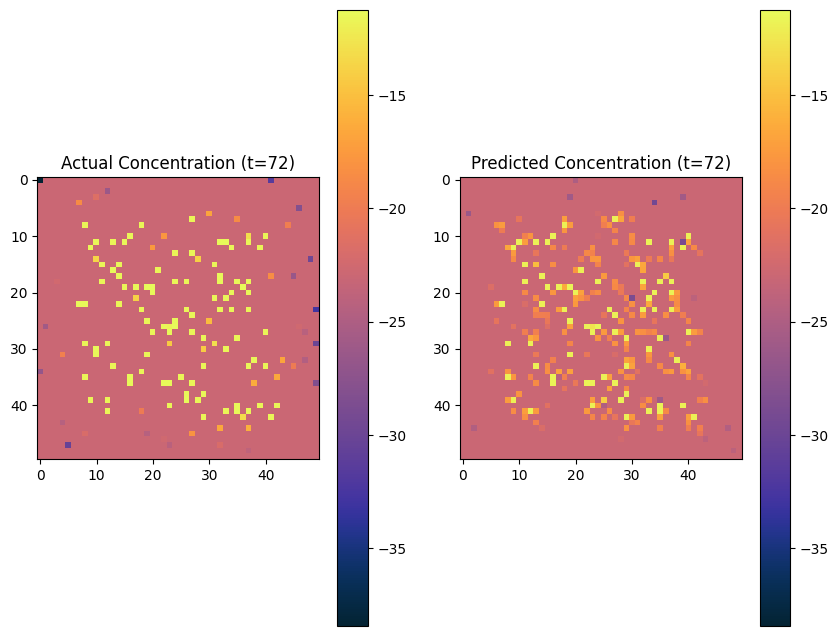

In [33]:
timesteps = [0]

# Flatten the y_pred and y_test tensors
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Handle zero or negative values before log transformation
epsilon = 1e-10  # Small constant to avoid log(0)

for t in timesteps:
    # Get the flattened values for the specified timestep
    y_pred_timestep = y_pred_flattened[t]
    y_test_timestep = y_test_flattened[t]

    # Avoid log(0) by replacing non-positive values
    y_pred_timestep = np.where(y_pred_timestep <= 0, epsilon, y_pred_timestep)
    y_test_timestep = np.where(y_test_timestep <= 0, epsilon, y_test_timestep)

    # Apply log scale
    log_y_test_flattened = np.log(y_test_timestep)
    log_y_pred_flattened = np.log(y_pred_timestep)

    # Reshape the feature data to a 50x50 grid
    y_test_grid = np.reshape(log_y_test_flattened[:, 0], (50, 50))
    y_pred_grid = np.reshape(log_y_pred_flattened[:, 0], (50, 50))

    # Calculate vmin and vmax to handle log transformation correctly
    vmin = min(y_test_grid.min(), y_pred_grid.min())
    vmax = max(y_test_grid.max(), y_pred_grid.max())

    plt.figure(figsize=(10, 8))

    # Plotting actual values
    plt.subplot(1, 2, 1)
    im1 = plt.imshow(y_test_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Actual Concentration (t={t+72})')
    plt.colorbar(im1)

    # Plotting predicted values
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(y_pred_grid, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax)
    plt.title(f'Predicted Concentration (t={t+72})')
    plt.colorbar(im2)

    # Save the plot to the specified folder
    output_dir = 'plots(50x50)/plots-C-LSTM'
    plot_filename = f'{timesteps.index(t) + 1}_grid at t={t+72}.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    plt.show()

**Plot actual vs predicted (blue) and actual vs actual (red) for best timestep in test set after flattening**

1/1 [==============================] - 0s 19ms/step
0
(2500, 6)
(2500, 6)


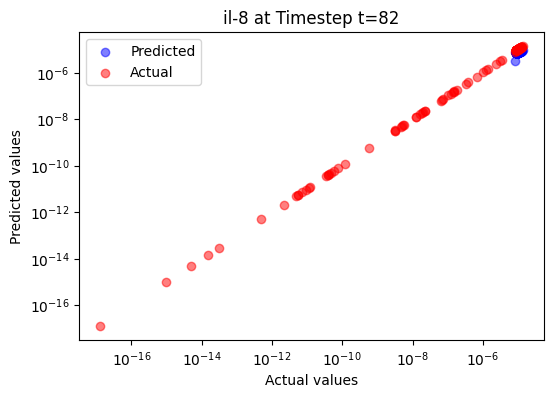

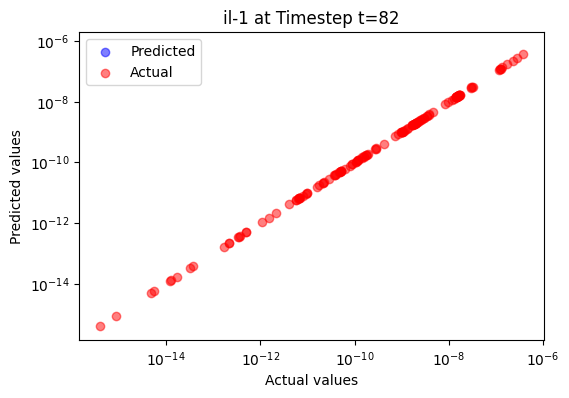

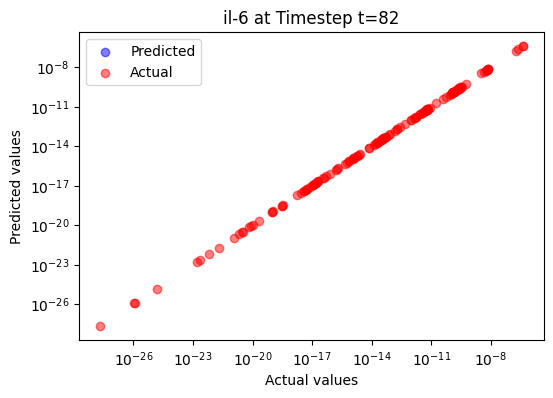

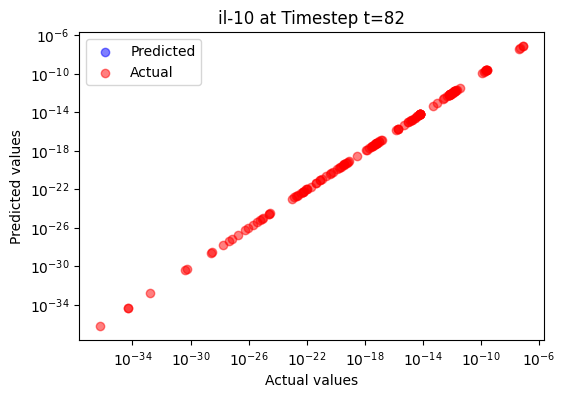

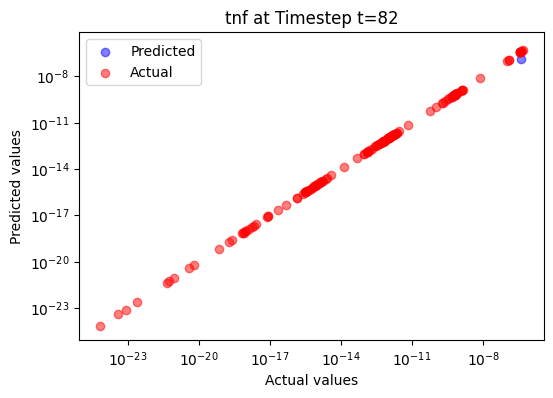

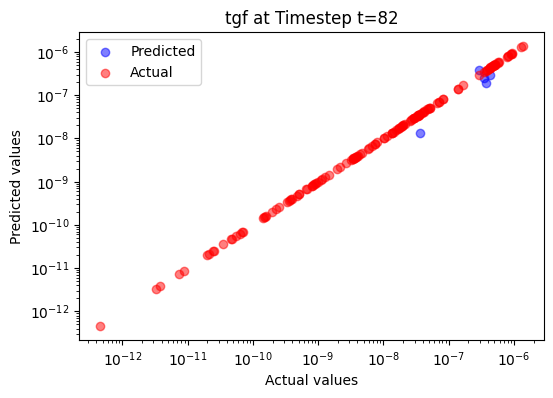

In [31]:
y_pred=model.predict(X_test)
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape

# Flatten the y_pred and y_test tensors
y_pred_flattened = np.reshape(y_pred, (y_pred_shape[0], -1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (y_test_shape[0], -1, y_test_shape[-1]))

# Calculate the mean squared error for each timestep
mse = np.mean((y_pred_flattened - y_test_flattened) ** 2, axis=(1, 2))

# Find the timestep with the smallest error
best_timestep = np.argmin(mse)
print(best_timestep)

# Get the flattened values for the best timestep
best_y_pred_flattened = y_pred_flattened[best_timestep]
best_y_test_flattened = y_test_flattened[best_timestep]

# Create arrays for x and y coordinates for the best timestep
X = np.repeat(np.arange(y_test_shape[1]), y_test_shape[2])
Y = np.tile(np.arange(y_test_shape[2]), y_test_shape[1])

# Verify shapes
print(best_y_test_flattened.shape)
print(best_y_pred_flattened.shape)

# Create plots for the best timestep
output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

num_features = best_y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(best_y_test_flattened[:, i], best_y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(best_y_test_flattened[:, i], best_y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'{labels[i]} at Timestep t=82')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # Save the plot to the specified folder
    plot_filename = f'{labels[i]}_at_timestep_t=82.png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

**Plot actual vs predicted (blue) and actual vs actual (red) for all the timesteps in the test set after flattening**

1/1 [==============================] - 0s 29ms/step
(19, 50, 50, 6)
(19, 50, 50, 6)
(47500, 6)
(47500, 6)


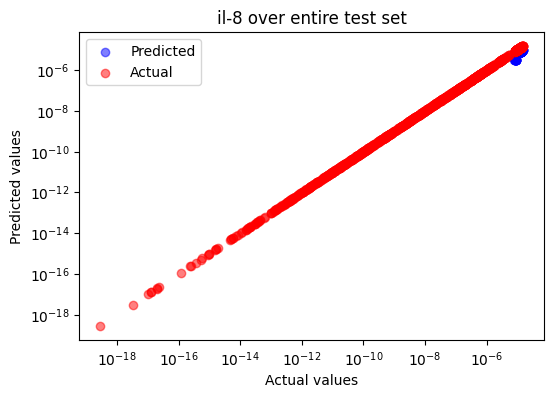

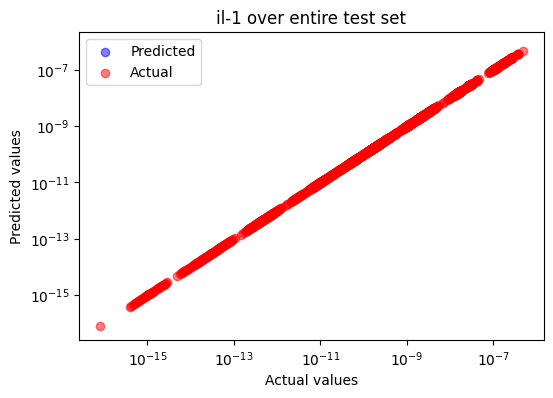

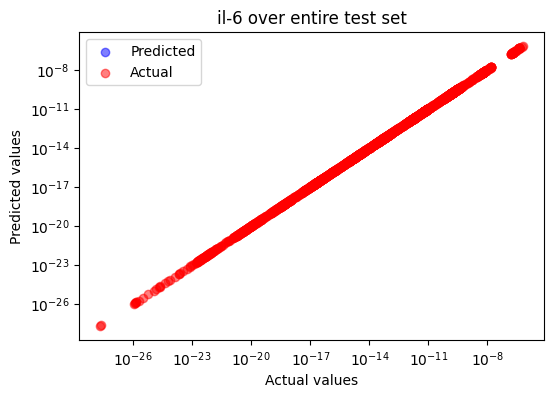

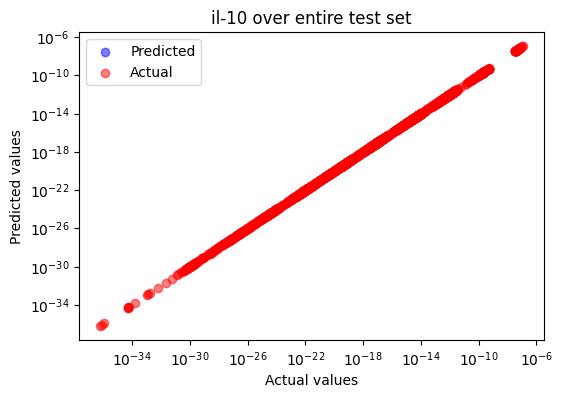

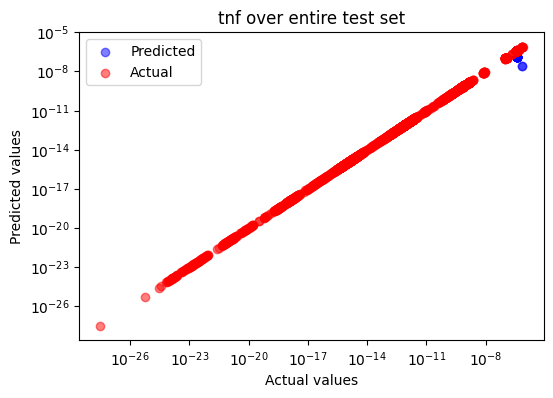

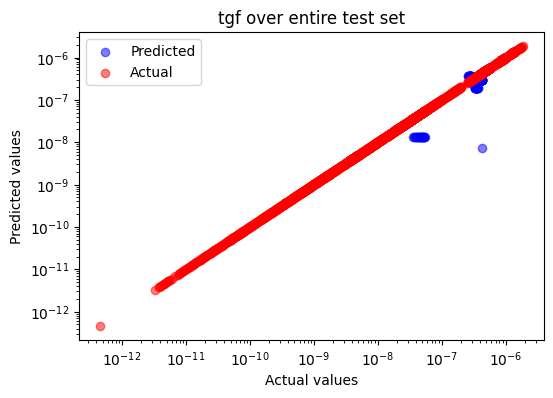

In [32]:
y_pred=model.predict(X_test)
print(y_test.shape)
print(y_pred.shape)
y_pred_shape = y_pred.shape
y_test_shape=y_test.shape

# reshape the tensor to (91*50*50, 6)
y_pred_flattened = np.reshape(y_pred, (-1, y_pred_shape[-1]))
y_test_flattened = np.reshape(y_test, (-1, y_test_shape[-1]))

df = pd.DataFrame(y_pred_flattened, columns=[f'feature_{i+1}' for i in range(y_pred_shape[-1])])

print(y_test_flattened.shape)
print(y_pred_flattened.shape)

output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

num_features = y_test_flattened.shape[1]
for i in range(num_features):
    plt.figure(figsize=(6, 4))
    plt.scatter(y_test_flattened[:, i], y_pred_flattened[:, i], color='blue', alpha=0.5, label='Predicted')
    plt.scatter(y_test_flattened[:, i], y_test_flattened[:, i], color='red', alpha=0.5, label='Actual')
    plt.title(f'{labels[i]} over entire test set')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    
    # save the plot to the specified folder
    plot_filename = f'{labels[i]}(t=82 to t=100).png'
    plot_path = os.path.join(output_dir, plot_filename)
    plt.savefig(plot_path)
    
    plt.show()

**Time series plot calculating mean and std**

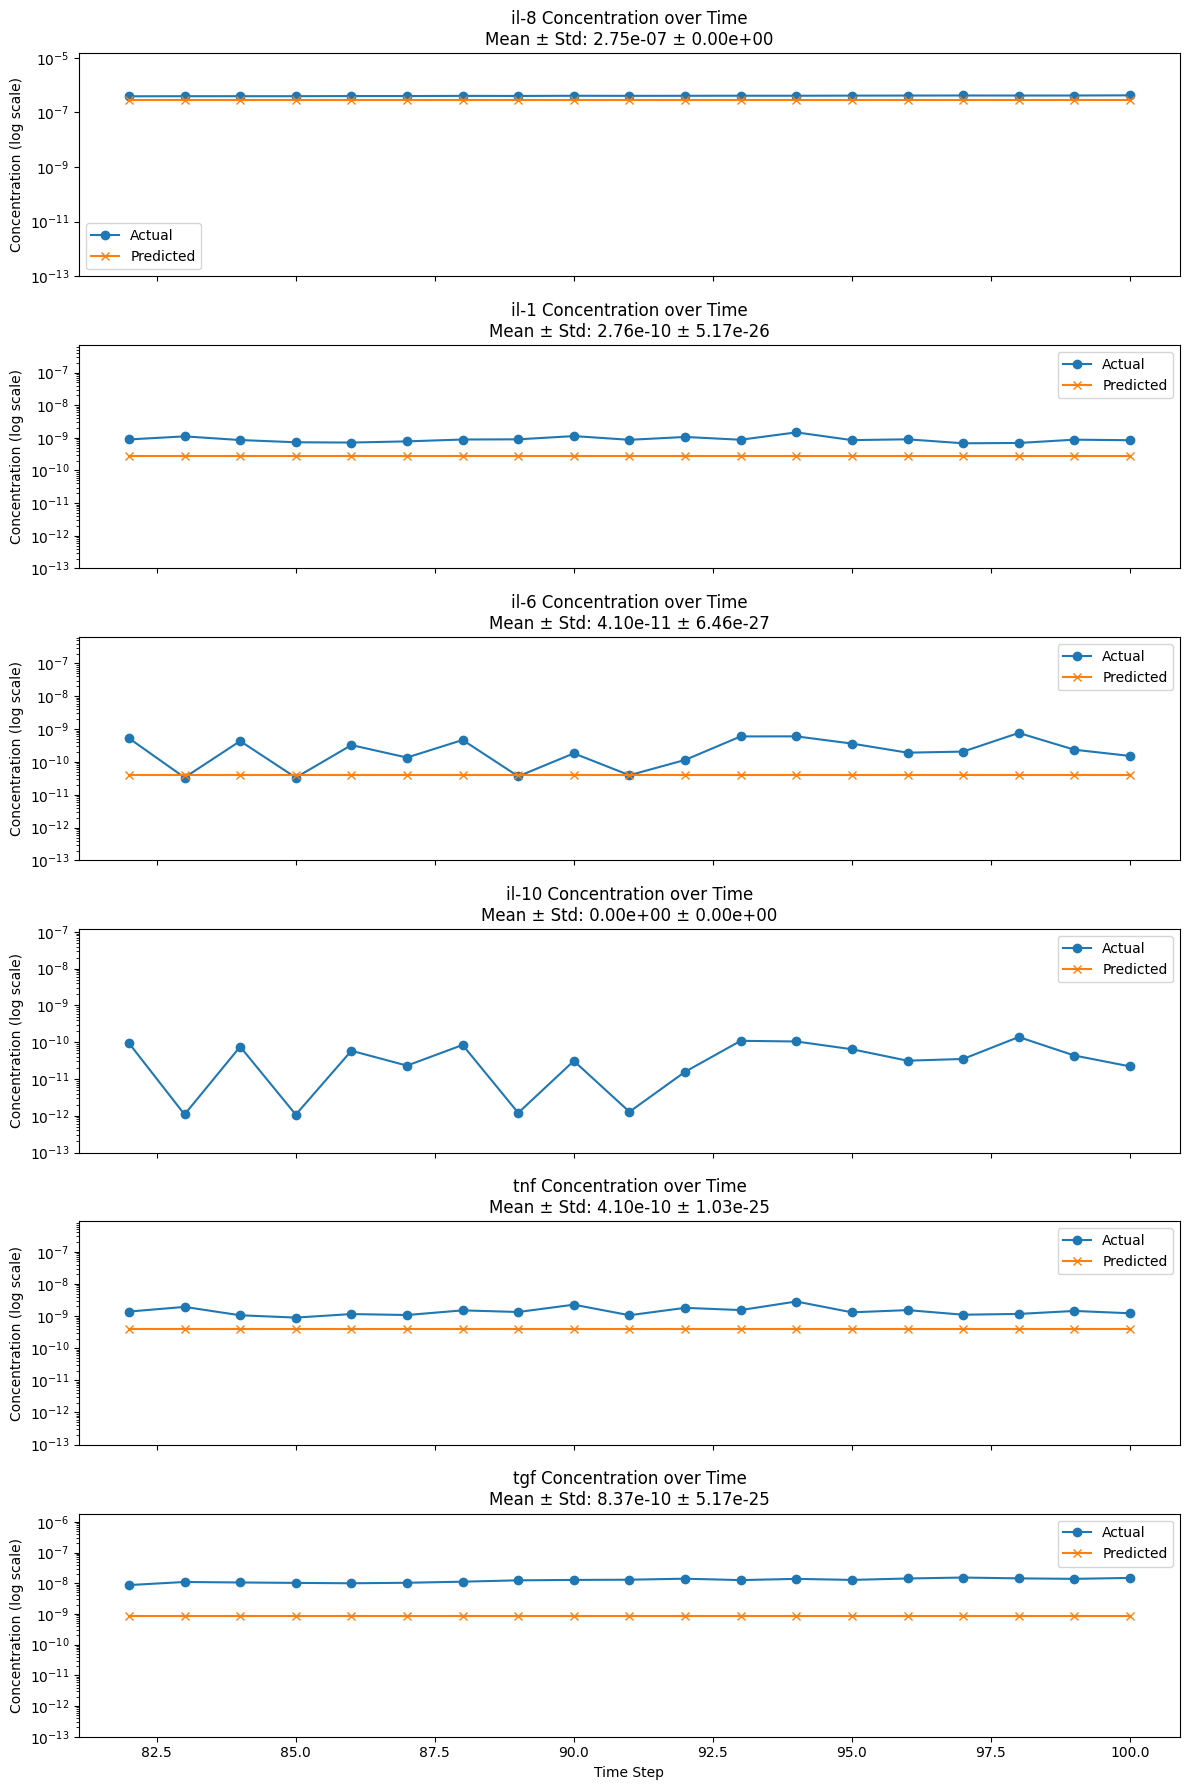

In [33]:
# Combine y_test and y_pred for easier range calculation
combined_data = np.concatenate([y_test, y_pred])

output_dir = 'plots-LSTM'
os.makedirs(output_dir, exist_ok=True)

# Mask zeros and small values, set lower limit for log scale
masked_data = np.ma.masked_equal(combined_data, 0)
lower_limit = 1e-13

# Calculate min and max values for each cytokine, ignoring zeros and clipping
min_values = np.ma.min(masked_data, axis=(0, 1, 2))
max_values = np.ma.max(masked_data, axis=(0, 1, 2))

# Convert masked arrays to regular arrays with NaN where masked
min_values = min_values.filled(np.nan)
max_values = max_values.filled(np.nan)

# Average over the spatial dimensions (X, Y coordinates)
y_test_avg = np.mean(y_test, axis=(1, 2))
y_pred_avg = np.mean(y_pred, axis=(1, 2))

# Calculate mean and std for each cytokine across all time steps
y_test_mean = np.mean(y_test_avg, axis=0)
y_pred_mean = np.mean(y_pred_avg, axis=0)
y_test_std = np.std(y_test_avg, axis=0)
y_pred_std = np.std(y_pred_avg, axis=0)

# Time steps (assuming they are from t=82 to t=100)
time_steps = np.arange(82, 101)

labels = ['il-8', 'il-1', 'il-6', 'il-10', 'tnf', 'tgf']

# Plotting
fig, axs = plt.subplots(6, 1, figsize=(12, 18), sharex=True)

for i in range(6):
    axs[i].plot(time_steps, y_test_avg[:, i], label='Actual', marker='o')
    axs[i].plot(time_steps, y_pred_avg[:, i], label='Predicted', marker='x')
    axs[i].set_title(f'{labels[i]} Concentration over Time\nMean ± Std: {y_pred_mean[i]:.2e} ± {y_pred_std[i]:.2e}')
    axs[i].set_ylabel('Concentration (log scale)')
    axs[i].set_yscale('log')
    axs[i].set_ylim(lower_limit, max_values[i])
    axs[i].legend()

axs[-1].set_xlabel('Time Step')

plt.tight_layout()

# save the plot to the specified folder
plot_filename = f'{labels[i]}(t=82 to t=100)(time series plot).png'
plot_path = os.path.join(output_dir, plot_filename)
plt.savefig(plot_path)
plt.show()

In [59]:
dataset2_path = 'data/PINN(72-100).csv' 

data2 = pd.read_csv(dataset2_path)

# Define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Remove brackets and convert to float in dataset 1
#for col in cytokines:
   # data[col] = data[col].str.strip('[]').astype(float)

# Filter for time = 72
data_72 = data[data['time'] == 100]
data2_72 = data2[data2['timestep'] == 100]

# Create a 50x50 grid representation for both datasets
grid_size = 50

def create_binary_grid(data, x_col, y_col, value_cols):
    grid = np.zeros((grid_size, grid_size))
    for _, row in data.iterrows():
        x, y = int(row[x_col]), int(row[y_col])
        if any(row[col] != 0 for col in value_cols):
            grid[x, y] = 1
    return grid

# Create binary grids
value_cols_data = cytokines
value_cols_data2 = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6']

grid1 = create_binary_grid(data_72, 'xCOM', 'yCOM', value_cols_data)
grid2 = create_binary_grid(data2_72, 'X', 'Y', value_cols_data2)

# Calculate accuracy
def calculate_accuracy(actual_grid, predicted_grid):
    actual_non_zero = np.sum(actual_grid)
    correct_predictions = np.sum((actual_grid == 1) & (predicted_grid == 1))
    accuracy = correct_predictions / actual_non_zero if actual_non_zero > 0 else 0
    return accuracy

accuracy = calculate_accuracy(grid1, grid2)

print(f"Accuracy of predictions for t=72: {accuracy * 100:.2f}%")

Accuracy of predictions for t=72: 61.82%


In [35]:
# Define cytokines
cytokines = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']
# Remove brackets and convert to float in dataset 1
for col in cytokines:
    data[col] = data[col].str.strip('[]').astype(float)

AttributeError: Can only use .str accessor with string values!

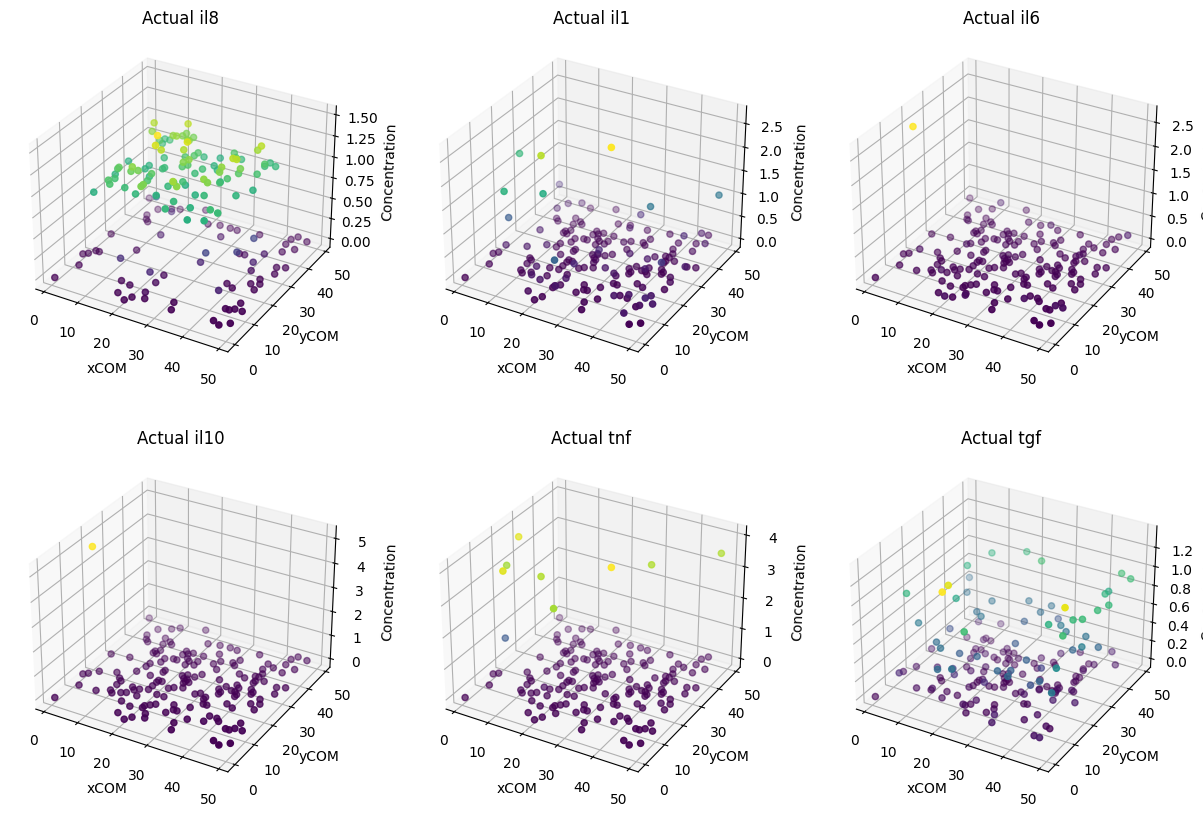

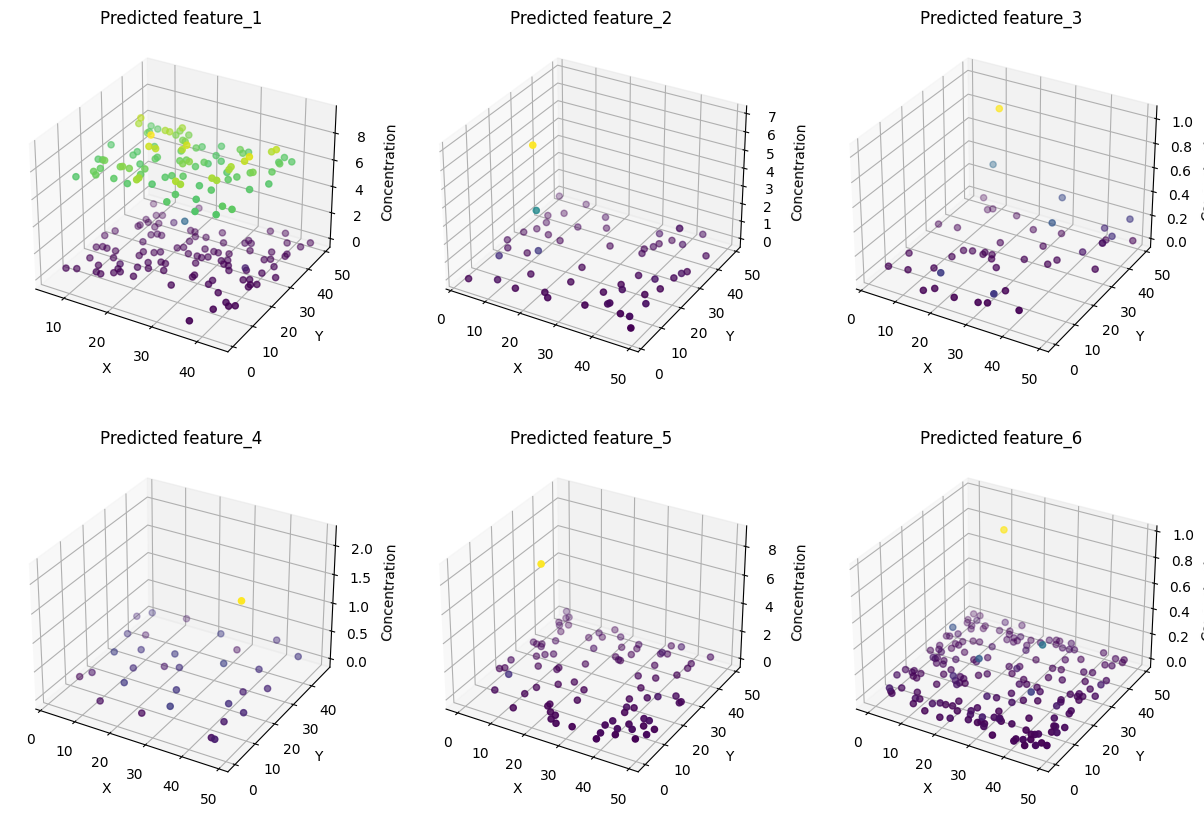

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load the predicted values dataset
predicted_df = pd.read_csv('data/PINN(72-100).csv')

# Filter the data for time=72 and timestep=72
actual_filtered = data[data['time'] == 100]
predicted_filtered = predicted_df[predicted_df['timestep'] == 100]

# Extract x, y coordinates and features for actual values
x_actual = actual_filtered['xCOM'].values
y_actual = actual_filtered['yCOM'].values
features_actual = ['il8', 'il1', 'il6', 'il10', 'tnf', 'tgf']

# Extract x, y coordinates and features for predicted values
x_pred = predicted_filtered['X'].values
y_pred = predicted_filtered['Y'].values
features_pred = ['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6']

# Define a fixed grid for X and Y values
x_grid = np.linspace(0, 50, 50)
y_grid = np.linspace(0, 50, 50)
x_fixed, y_fixed = np.meshgrid(x_grid, y_grid)

# Function to filter out zero values and map to fixed grid
def filter_and_map_to_grid(x, y, z, x_fixed, y_fixed):
    x_nonzero = x[z != 0]
    y_nonzero = y[z != 0]
    z_nonzero = z[z != 0]
    
    x_idx = np.array([np.abs(x_fixed[0] - xi).argmin() for xi in x_nonzero])
    y_idx = np.array([np.abs(y_fixed[:, 0] - yi).argmin() for yi in y_nonzero])
    
    z_fixed = np.zeros_like(x_fixed, dtype=float)
    for i in range(len(x_nonzero)):
        z_fixed[y_idx[i], x_idx[i]] = z_nonzero[i]
    
    return x_fixed[z_fixed != 0], y_fixed[z_fixed != 0], z_fixed[z_fixed != 0]

# Create 3D scatter plots for actual values
fig_actual = plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_actual):
    ax = fig_actual.add_subplot(2, 3, i + 1, projection='3d')
    z_actual = np.array([float(val[0]) if isinstance(val, list) else float(val) for val in actual_filtered[feature]])
    x_plot, y_plot, z_plot = filter_and_map_to_grid(x_actual, y_actual, z_actual, x_fixed, y_fixed)
    ax.scatter(x_plot, y_plot, z_plot, c=z_plot, cmap='viridis')
    ax.set_title(f'Actual {feature}')
    ax.set_xlabel('xCOM')
    ax.set_ylabel('yCOM')
    ax.set_zlabel('Concentration')

# Create 3D scatter plots for predicted values
fig_pred = plt.figure(figsize=(15, 10))
for i, feature in enumerate(features_pred):
    ax = fig_pred.add_subplot(2, 3, i + 1, projection='3d')
    z_pred = predicted_filtered[feature].values
    x_plot, y_plot, z_plot = filter_and_map_to_grid(x_pred, y_pred, z_pred, x_fixed, y_fixed)
    ax.scatter(x_plot, y_plot, z_plot, c=z_plot, cmap='viridis')
    ax.set_title(f'Predicted {feature}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Concentration')

plt.show()